# Skin lesion classification

**Deadline**: Upload this notebook (rename it as 'TP-SVM-YOUR-SURNAME.ipynb') to Ecampus before the deadline.


**Context**
A skin lesion is defined as a superficial growth or patch of the skin that is visually different and/or has a different texture than its surrounding area. Skin lesions, such as moles or birthmarks, can degenerate and become melanoma, one of the deadliest skin cancer. Its incidence has been increasing during the last decades, especially in the areas mostly populated by white people.

The most effective treatment is an early detection followed by surgical excision. This is why several approaches for melanoma detection have been proposed in the last years (non-invasive computer-aided diagnosis (CAD) ).


**Goal**
The goal of this practical session is to classify images of skin lesions as either benign or melanoma using machine learning algorithms. In order to do that, you will have at your disposal a set of 30 features already extracted from 600 dermoscopic images (both normal skin lesions and melanoma from the ISIC database - https://isic-archive.com/). These features characterize the Asymmetry, the Border irregularity, the Colour and the Dimension of the lesion (the so-called ABCD rule). 

The features are:
- shape asimmetry (f0 and f1)
- difference in colors between center and periphery of the image (f2, f3, f4, f27, f28, f29)
- geometry (f5, f6, f7)
- other features related to eccentricity,entropy, mean, standard deviation and maximum value of each channel in RGB and HSV (f8,...,f24)
- asimmetry of color intensity (f25, f26)

Features are computed using *manually checked segmentations* and following *Ganster et al. 'Automated melanoma recognition', IEEE TMI, 2001* and *Zortea et al. 'Performance of a dermoscopy-based computer vision system for the diagnosis of pigmented skin lesions compared with visual evaluation by experienced dermatologists', Artificial Intelligence in Medicine, 2014*.

First load all necessary packages

In [1]:
import os
import numpy as np
import pandas as pd
from skimage.io import imread
from time import time
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.model_selection import  cross_val_score
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import GridSearchCV, KFold, cross_validate
from sklearn.linear_model import Perceptron
from sklearn.decomposition import PCA

%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

# Code from scikit-learn
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


Then load the data from my Google Drive

In [2]:
pip install googledrivedownloader

Note: you may need to restart the kernel to use updated packages.


In [3]:

from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id='18hrQVGBCfW7SKTnzmWUONo8iowBsi1DL',
dest_path='./data/features.csv')
gdd.download_file_from_google_drive(file_id='1iQZdUiuK_FwZ7mik7LB3eN_H_IUc5l7b',
dest_path='./data/im/nevus-seg.jpg')
gdd.download_file_from_google_drive(file_id='1_TeYzLLDoKbPX4xXAOAM_mQiT2nLHgvp',
dest_path='./data/im/nevus.jpg')
gdd.download_file_from_google_drive(file_id='1B2Ol92mBcHN6ah3bpoucBbBbHkPMGC8D',
dest_path='./data/im/melanoma-seg.jpg')
gdd.download_file_from_google_drive(file_id='1yZ46UzGhwO7g5T8397JpewBl6UqgRo5J',
dest_path='./data/im/melanoma.jpg')

Or from yout local computer. Please download the 'data' folder in the same folder as your notebook and do not modifiy it.

Then read the data 

In [4]:
## Read data
Working_directory="./data/" 
df = pd.read_csv(Working_directory + 'features.csv') # reading data
y = df['Malignant'].values # 1 for Melanoma and 0 for healthy
class_names = ["healthy","melanoma"]
X = df.iloc[:,3:33].values # Features
N,M=X.shape
print('Number of images: {0}; Number of features per image: {1}'.format(N,M))
print('Number of healthy nevus: {0}; Number of melanoma: {1}'.format(N-np.sum(y), np.sum(y)))


Number of images: 600; Number of features per image: 30
Number of healthy nevus: 485; Number of melanoma: 115


Two examples of healthy nevus and melanoma


Text(0.5, 1.0, 'Segmented melanoma')

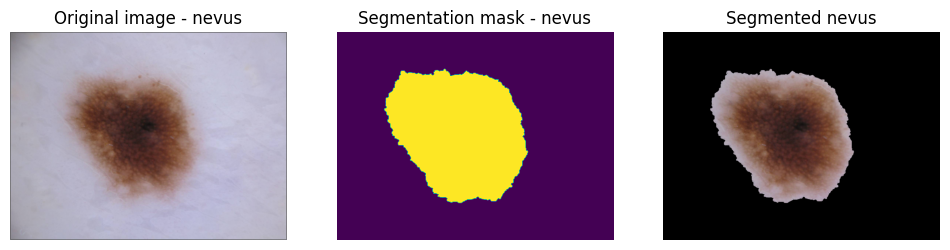

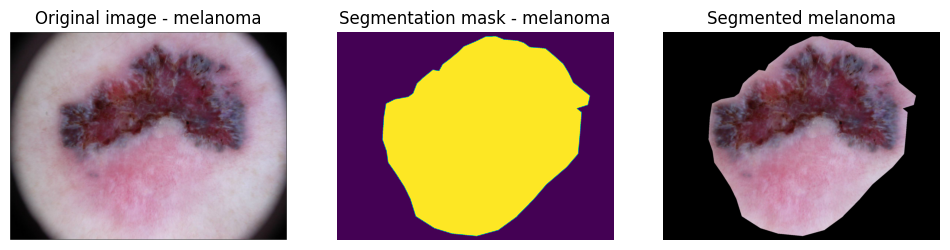

In [5]:
## Plot two examples of nevus and melanoma
print('Two examples of healthy nevus and melanoma')
nevus = imread(Working_directory + 'im/nevus.jpg')
nevus_Segmentation = imread(Working_directory + 'im/nevus-seg.jpg') 
nevus_Segmentation_boolean = (nevus_Segmentation/255).astype(np.uint8) # To get uint8 (integer numbers)
nevus_Segmentation_3D = np.expand_dims(nevus_Segmentation_boolean, axis=2) # To have a binary mask for the three channels (RGB)
nevus_mul_mask = (nevus_Segmentation_3D*nevus) # we apply the binary mask to all channels pixel-wise

fig = plt.figure(figsize=(12, 12)) # size of the figure
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 3),
                axes_pad = 0.5) # code to create subplots
grid[0].imshow(nevus)
grid[0].axis('off')
grid[0].set_title('Original image - nevus')
grid[1].imshow(nevus_Segmentation)
grid[1].axis('off')
grid[1].set_title("Segmentation mask - nevus")
grid[2].imshow(nevus_mul_mask)
grid[2].axis('off')
grid[2].set_title("Segmented nevus")

###

melanoma = imread(Working_directory + 'im/melanoma.jpg')
melanoma_Segmentation = imread(Working_directory + 'im/melanoma-seg.jpg') 
melanoma_Segmentation_boolean = (melanoma_Segmentation/255).astype(np.uint8) # To get uint8 (integer numbers)
melanoma_Segmentation_3D = np.expand_dims(melanoma_Segmentation_boolean, axis=2) # To have a binary mask for the three channels (RGB)
melanoma_mul_mask = (melanoma_Segmentation_3D*melanoma) # we apply the binary mask to all channels pixel-wise

fig = plt.figure(figsize=(12, 12)) # size of the figure
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 3),
                axes_pad = 0.5) # code to create subplots
grid[0].imshow(melanoma)
grid[0].axis('off')
grid[0].set_title('Original image - melanoma')
grid[1].imshow(melanoma_Segmentation)
grid[1].axis('off')
grid[1].set_title("Segmentation mask - melanoma")
grid[2].imshow(melanoma_mul_mask)
grid[2].axis('off')
grid[2].set_title("Segmented melanoma")


Now, as in the previous practical session you should shuffle the data randomly

In [6]:
# Shuffle data randomly
from sklearn.utils import shuffle

Xp = X.copy()
yp = y.copy()
Xp, yp = shuffle(Xp, yp)


We should now test the discriminative power of our features. Fist, let divide the entire data-set into training and test set using the `stratify` option. This will preserve the original proportion between nevus and melanoma also in the training and test set. You can check that from the plot.

Text(0, 0.5, 'Proportion')

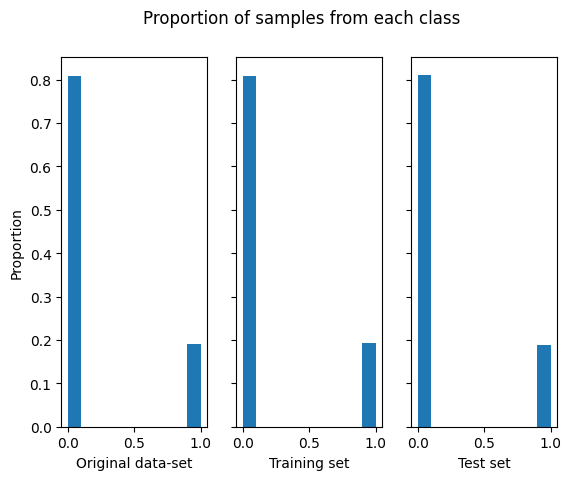

In [7]:
# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(Xp, yp, test_size=0.3, random_state=42,stratify=yp)

fig, axs = plt.subplots(1, 3, sharey=True)
fig.suptitle('Proportion of samples from each class')
axs[0].hist(yp,weights=np.ones_like(yp)/len(yp))
axs[0].set_xlabel('Original data-set')
axs[1].hist(y_train,weights=np.ones_like(y_train)/len(y_train))
axs[1].set_xlabel('Training set')
axs[2].hist(y_test,weights=np.ones_like(y_test)/len(y_test))
axs[2].set_xlabel('Test set')
axs[0].set_ylabel('Proportion')

As we have already seen, it might be very important to scale the data such that each feature has, for instance, average equal to 0 and unit variance. Which is the right way of doing it when having a training and a test set in your opinion ? Should you use together both training and test set ?

**Answer:** 

If the mean and standard deviation are computed using both the training and test data, then the test set is no longer a true evaluation of the model's performance on unseen data. In this case, knowledge about the distribution of the test set would be used to set the scale of the training set, "leaking" information.

Similarly, using the training mean and standard deviation to scale the training set and the test mean and standard deviation to scale the test set is not a good idea. In this case, a test variable with a value equals to 1.0 would have a different original value than a training example with a value equals to 1.0, but would be treated identically by the model. 

Therefore, it is important to compute the mean and standard deviation of each feature in the training set only, and use these values to transform both the training and test sets consistently. 

In [8]:
# Scale data (each feature will have average equal to 0 and unit variance)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train, y_train)
X_test = scaler.transform(X_test)


Now, use two simple classification algorithms, for instance LDA and QDA, and look at the confusion matrices. 

**Question**: Comment the results. 

**Answer**: 

Concerning the precision of the LDA classifier, we can observe that out of all the lesions that the model predicted would be benign, 86% of them were actually benign and out of all the lesions that the model predicted would be malignant, 42% of them were actually malign. Concerning its recall, out of all the melanoma lesions, the model only predicted this outcome correclty for 41% of them, while among the benign lesions, the model predicted this outcome correctly for 87% of them.

Concerning the QDA result we can observe that out of all the lesions that the model predicted would be benign, 84% of them were actually benign and out of all the lesions that the model predicted would be malignant, 43% of them were actually malign. Concerning its recall, out of all the melanoma lesions, the model only predicted this outcome correclty for 26% of them, while among the benign lesions, the model predicted this outcome correctly for 92% of them.

The results are very similar and both methods present a poor recall for melanomas. Both f1-scores indicate that the models are better fitted to predict benign lesions than malignant lesions. 

The fact that both models have similar results suggests that the data may be inherently difficult to classify, or that both models suffer from similar limitations. The fact that the model predicts better benign lesions than malignant lesions could be due to an imbalance in the number of benign and malignant lesions in the dataset or other factors such as the complexity of the features used for the classification.

Fitting LDA to training set
              precision    recall  f1-score   support

           0       0.85      0.91      0.88       146
           1       0.43      0.29      0.35        34

    accuracy                           0.79       180
   macro avg       0.64      0.60      0.61       180
weighted avg       0.77      0.79      0.78       180

Normalized confusion matrix
[[0.9109589  0.0890411 ]
 [0.70588235 0.29411765]]


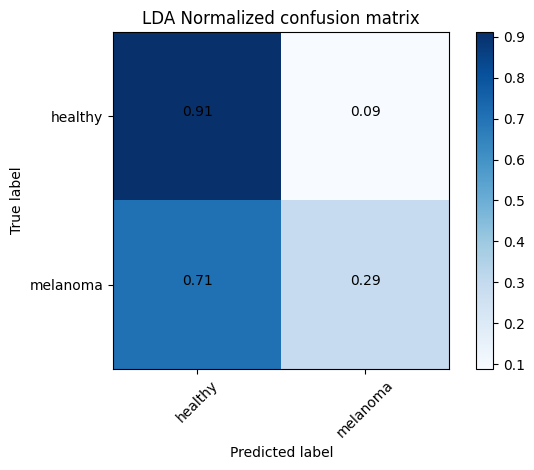

Fitting QDA to training set
              precision    recall  f1-score   support

           0       0.87      0.93      0.90       146
           1       0.57      0.38      0.46        34

    accuracy                           0.83       180
   macro avg       0.72      0.66      0.68       180
weighted avg       0.81      0.83      0.81       180

Normalized confusion matrix
[[0.93150685 0.06849315]
 [0.61764706 0.38235294]]


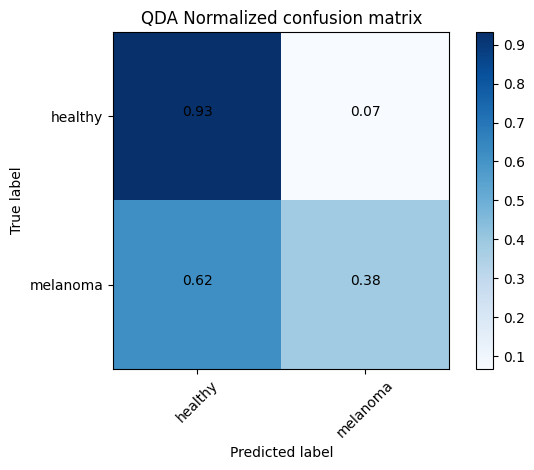

In [9]:
# Fitting LDA
print("Fitting LDA to training set")
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
y_pred = lda.predict(X_test)
print(classification_report(y_test, y_pred))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='LDA Normalized confusion matrix')
plt.show()

# Fitting QDA
print("Fitting QDA to training set")
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train, y_train)
y_pred = qda.predict(X_test)
print(classification_report(y_test, y_pred))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                        title='QDA Normalized confusion matrix')
plt.show()

The results you obtained are based on a precise subdivision of your data into training and test. This can thus bias your results. Which technique could you use instead ? Test it  with LDA, QDA and K-NN.

**Answer:** Cross-validation is a technique that can be used to estimate the performance of a machine learning algorithm with less variance than a single train-test set split.  

In [10]:
# Fitting LDA
lda = LinearDiscriminantAnalysis()
scores = cross_val_score(lda, Xp, yp, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


# Fitting QDA
qda = QuadraticDiscriminantAnalysis()
scores = cross_val_score(qda, Xp, yp, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

# Fitting K-nearest neighbour
knn = KNeighborsClassifier(n_neighbors=5)
scores = cross_val_score(knn, Xp, yp, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


Accuracy: 0.82 (+/- 0.08)
Accuracy: 0.80 (+/- 0.07)
Accuracy: 0.78 (+/- 0.06)


When using K-NN, instead than fixing the number of nearest neighbours, we could also estimate the best value using Cross Validation. Do it and plot the confusion matrix. Do you notice anything strange ? Why in your opinion do you have this kind of result ?

**Answer:** As it could be seen below, the confusion matrix presents a very high number of false negatives (melanoma classified as healthy). This can be explained by the fact that we have an uneven distribution of the classes in the dataset (class imbalance). The model is biased towards the majority class (benign lesions) and therefore it is more likely to predict a benign lesion than a malignant one. This is a common problem in medical diagnosis, where the number of healthy patients is usually much higher than the number of patients with a disease.   

Best training Score: 0.8238095238095238
Best training params: {'n_neighbors': 6}
[[142   4]
 [ 25   9]]
              precision    recall  f1-score   support

           0       0.85      0.97      0.91       146
           1       0.69      0.26      0.38        34

    accuracy                           0.84       180
   macro avg       0.77      0.62      0.65       180
weighted avg       0.82      0.84      0.81       180

Normalized confusion matrix
[[0.97260274 0.02739726]
 [0.73529412 0.26470588]]


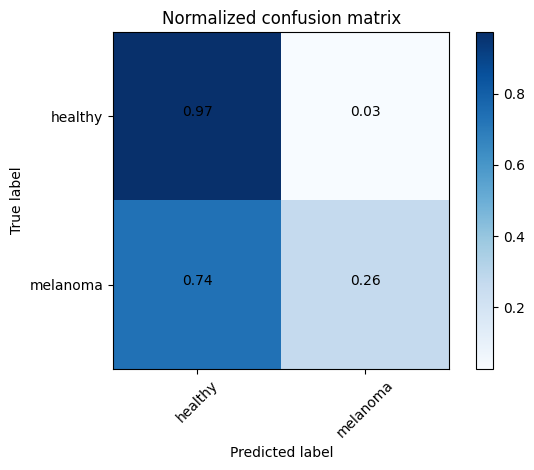

In [11]:
# Looking for the best hyperparameters
p_grid_KNN = {'n_neighbors': [1,2,3,4,5,6,7,8,9,10]}
KNN = KNeighborsClassifier()
grid_KNN = GridSearchCV(estimator=KNN, param_grid=p_grid_KNN, scoring="accuracy", cv=5)
grid_KNN.fit(X_train, y_train)
print("Best training Score: {}".format(grid_KNN.best_score_))
print("Best training params: {}".format(grid_KNN.best_params_))
y_pred = grid_KNN.predict(X_test)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
print(cnf_matrix)

# print classification report
print(classification_report(y_test, y_pred))

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In order to deal with this problem we have two possible solutions. 

**First**: Please look at this webpage (https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter) and try MORE APPROPRIATE scoring functions than accuracy when looking for the best K value of K-NN (thus within the Cross Validation as before..).

Scoring technique: accuracy
Best training params: {'n_neighbors': 6}
              precision    recall  f1-score   support

           0       0.85      0.97      0.91       146
           1       0.69      0.26      0.38        34

    accuracy                           0.84       180
   macro avg       0.77      0.62      0.65       180
weighted avg       0.82      0.84      0.81       180

Normalized confusion matrix
[[0.97260274 0.02739726]
 [0.73529412 0.26470588]]


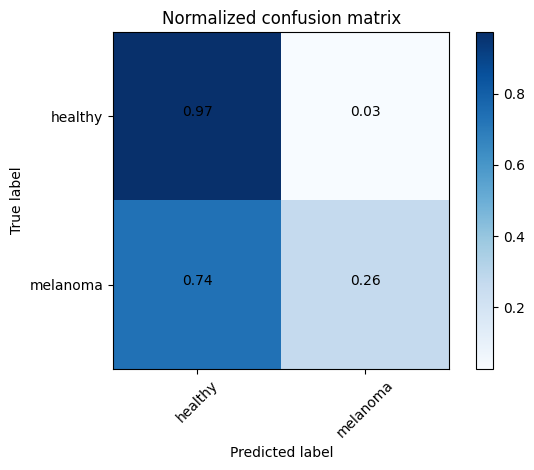

Scoring technique: f1
Best training params: {'n_neighbors': 1}
              precision    recall  f1-score   support

           0       0.87      0.79      0.83       146
           1       0.35      0.50      0.41        34

    accuracy                           0.73       180
   macro avg       0.61      0.64      0.62       180
weighted avg       0.77      0.73      0.75       180

Normalized confusion matrix
[[0.78767123 0.21232877]
 [0.5        0.5       ]]


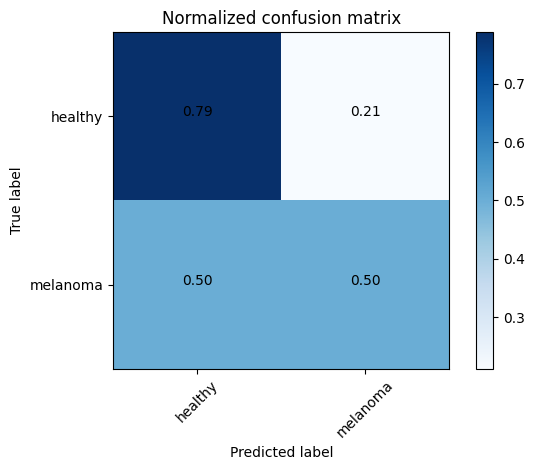

Scoring technique: recall
Best training params: {'n_neighbors': 1}
              precision    recall  f1-score   support

           0       0.87      0.79      0.83       146
           1       0.35      0.50      0.41        34

    accuracy                           0.73       180
   macro avg       0.61      0.64      0.62       180
weighted avg       0.77      0.73      0.75       180

Normalized confusion matrix
[[0.78767123 0.21232877]
 [0.5        0.5       ]]


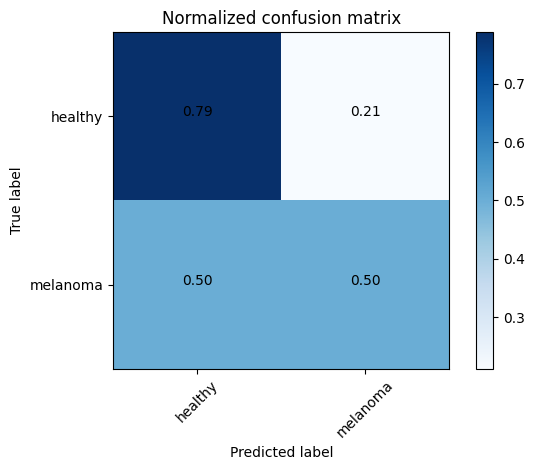

In [12]:
# Looking for the best hyperparameters
p_grid_KNN = {'n_neighbors': [1,2,3,4,5,6,7,8,9,10]}
KNN = KNeighborsClassifier()
scoring_technique = ['accuracy', 'f1', 'recall']

for scoring in scoring_technique:
    grid_KNN = GridSearchCV(estimator=KNN, param_grid=p_grid_KNN, scoring=scoring, cv=5);
    grid_KNN.fit(X_train, y_train);
    print("Scoring technique: {}".format(scoring));
    print("Best training params: {}".format(grid_KNN.best_params_));
    y_pred = grid_KNN.predict(X_test)
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_pred);
    
    # print report 
    print(classification_report(y_test, y_pred))
    
    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                            title='Normalized confusion matrix')
    plt.show()

**Second**: when dealing with such a problem (the one you should find !) a possible solution would be to oversample a class (which one in your opinion ?) Please look at this web page for more information (https://imbalanced-learn.readthedocs.io/en/stable/over_sampling.html) and try at least one naive random over-sampling (look at the following code...).

**Answer:** In general, we should oversample the minority class because it is the class that has fewer samples than the majority class. Oversampling the minority class can help balance the class distribution and reduce the bias towards the majority class.

In [13]:
!pip install imbalanced-learn

In [14]:
from imblearn.over_sampling import ADASYN
from collections import Counter
print("auto: equivalent to not-majority")
ros = ADASYN(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
print(sorted(Counter(y_resampled).items()))

auto: equivalent to not-majority
[(0, 339), (1, 363)]


Let's look for the best K in KNN (as before using Cross validation) but this time on the new training set. 

**Question**: Are the results better ? Do they change now if you modify the scoring function ? Why ?

The results are better but in the case of the 'accuracy' score, the number of false negatives is still very high. This is because the accuracy score is not always a good metric for problems with different costs for misclassification between classes as in a medical diagnosis problem, where misclassifying a patient with a disease as healthy could be much more costly than misclassifying a healthy person as having a disease.

Therefore, metrics such as precision, recall, F1-score, and area under the ROC curve (AUC-ROC) are often more appropriate for classification problems because they take into account the number of true positives, false positives, true negatives, and false negatives, and they can be adjusted to reflect the specific cost of misclassification for different classes, providing a more comprehensive evaluation of the performance of a classification model, speacially for unbalanced datasets and medical problems.


Scoring technique: accuracy
Best training params: {'n_neighbors': 2}
              precision    recall  f1-score   support

           0       0.89      0.71      0.79       146
           1       0.33      0.62      0.43        34

    accuracy                           0.69       180
   macro avg       0.61      0.66      0.61       180
weighted avg       0.78      0.69      0.72       180

Normalized confusion matrix
[[0.71232877 0.28767123]
 [0.38235294 0.61764706]]


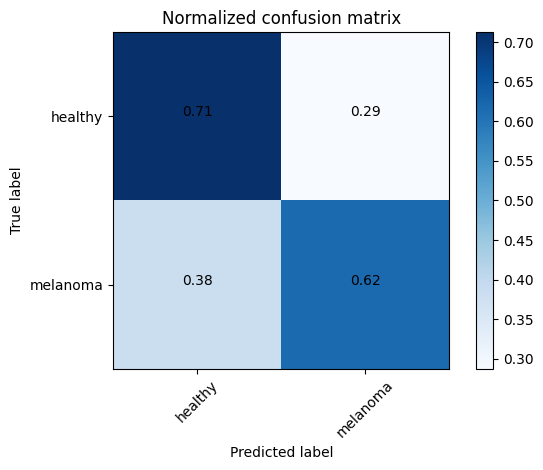

Scoring technique: f1
Best training params: {'n_neighbors': 1}
              precision    recall  f1-score   support

           0       0.89      0.63      0.74       146
           1       0.30      0.68      0.41        34

    accuracy                           0.64       180
   macro avg       0.60      0.65      0.58       180
weighted avg       0.78      0.64      0.68       180

Normalized confusion matrix
[[0.63013699 0.36986301]
 [0.32352941 0.67647059]]


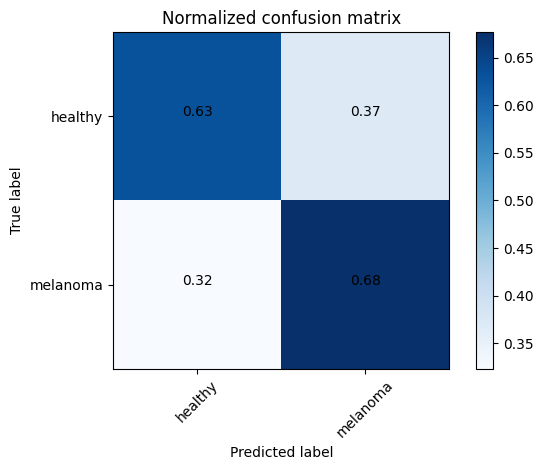

Scoring technique: recall
Best training params: {'n_neighbors': 1}
              precision    recall  f1-score   support

           0       0.89      0.63      0.74       146
           1       0.30      0.68      0.41        34

    accuracy                           0.64       180
   macro avg       0.60      0.65      0.58       180
weighted avg       0.78      0.64      0.68       180

Normalized confusion matrix
[[0.63013699 0.36986301]
 [0.32352941 0.67647059]]


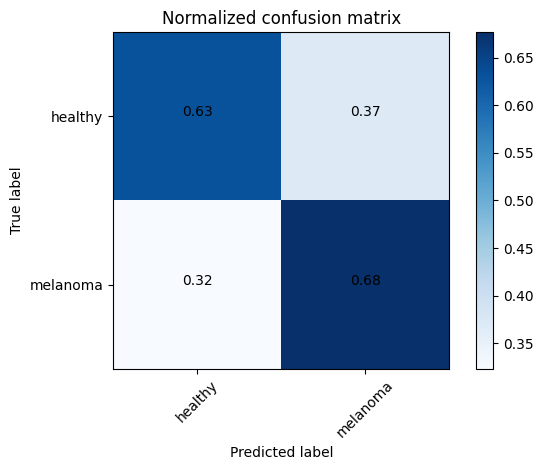

Scoring technique: roc_auc
Best training params: {'n_neighbors': 4}
              precision    recall  f1-score   support

           0       0.93      0.62      0.74       146
           1       0.33      0.79      0.46        34

    accuracy                           0.65       180
   macro avg       0.63      0.71      0.60       180
weighted avg       0.81      0.65      0.69       180

Normalized confusion matrix
[[0.61643836 0.38356164]
 [0.20588235 0.79411765]]


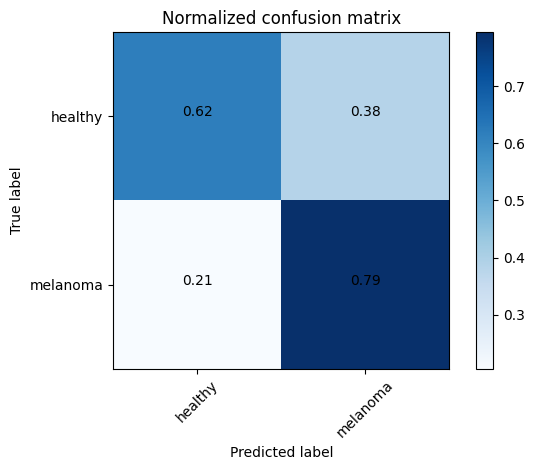

In [15]:
p_grid_KNN = {'n_neighbors': [1,2,3,4,5,6,7,8,9,10]}
KNN = KNeighborsClassifier()
scoring_technique = ['accuracy', 'f1', 'recall',
                     'roc_auc']

for scoring in scoring_technique:
    grid_KNN = GridSearchCV(estimator=KNN, param_grid=p_grid_KNN, scoring=scoring, cv=5)
    grid_KNN.fit(X_resampled, y_resampled)
    print("Scoring technique: {}".format(scoring))
    print("Best training params: {}".format(grid_KNN.best_params_))
    y_pred = grid_KNN.predict(X_test)
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_pred);
    
    print(classification_report(y_test, y_pred))

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                            title='Normalized confusion matrix')
    plt.show()

Let's use the techniques seen today: Perceptron and linear SVM. 

In [16]:
# Fitting Perceptron
print("Fitting Perceptron")
Perc = Perceptron()
Perc_cv = cross_validate(Perc,Xp, yp,cv=5,scoring='accuracy',return_train_score=True)
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Perc_cv['train_score'].mean(), Perc_cv['train_score'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Perc_cv['test_score'].mean(), Perc_cv['test_score'].std() ))

# Fitting linear SVM 
print("Fitting Linear SVM")
Lsvm = LinearSVC() 
Lsvm_cv = cross_validate(Lsvm,Xp, yp,cv=5,scoring='accuracy',return_train_score=True)
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Lsvm_cv['train_score'].mean(), Lsvm_cv['train_score'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Lsvm_cv['test_score'].mean(), Lsvm_cv['test_score'].std() ))

Fitting Perceptron
 Average and std TRAIN CV accuracy : 0.6408333333333334 +- 0.2312503753750707
 Average and std TEST CV accuracy : 0.6316666666666666 +- 0.22018931248662668
Fitting Linear SVM
 Average and std TRAIN CV accuracy : 0.8066666666666666 +- 0.002429563289518867
 Average and std TEST CV accuracy : 0.8099999999999999 +- 0.008164965809277232


We can easily use different scoring functions within the cross validate function of scikit-learn. Check the code.

In [17]:
# Fitting Perceptron
print("Fitting Perceptron")
Perc = Perceptron()
Perc_cv = cross_validate(Perc,Xp, yp,cv=5,scoring=('accuracy', 'f1', 'recall', 'roc_auc'),return_train_score=True)
print(Perc_cv.keys())
# print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Perc_cv['train_accuracy'].mean(), Perc_cv['train_accuracy'].std() ))
# print(" Average and std TEST CV accuracy : {0} +- {1}".format(Perc_cv['test_accuracy'].mean(), Perc_cv['test_accuracy'].std() ))
print(" Average and std TRAIN CV f1 : {0} +- {1}".format(Perc_cv['train_f1'].mean(), Perc_cv['train_f1'].std() ))
print(" Average and std TEST CV f1 : {0} +- {1}".format(Perc_cv['test_f1'].mean(), Perc_cv['test_f1'].std() ))
print(" Average and std TRAIN CV recall : {0} +- {1}".format(Perc_cv['train_recall'].mean(), Perc_cv['train_recall'].std() ))
print(" Average and std TEST CV recall : {0} +- {1}".format(Perc_cv['test_recall'].mean(), Perc_cv['test_recall'].std() ))
print(" Average and std TRAIN CV roc_auc : {0} +- {1}".format(Perc_cv['train_roc_auc'].mean(), Perc_cv['train_roc_auc'].std() ))
print(" Average and std TEST CV roc_auc : {0} +- {1}".format(Perc_cv['test_roc_auc'].mean(), Perc_cv['test_roc_auc'].std() ))

# Fitting linear SVM 
print("Fitting Linear SVM")
Lsvm = LinearSVC() 
Lsvm_cv = cross_validate(Lsvm,Xp, yp,cv=5,scoring=('accuracy', 'f1', 'recall', 'roc_auc'),return_train_score=True)
# print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Lsvm_cv['train_accuracy'].mean(), Lsvm_cv['train_accuracy'].std() ))
# print(" Average and std TEST CV accuracy : {0} +- {1}".format(Lsvm_cv['test_accuracy'].mean(), Lsvm_cv['test_accuracy'].std() ))
print(" Average and std TRAIN CV f1 : {0} +- {1}".format(Lsvm_cv['train_f1'].mean(), Lsvm_cv['train_f1'].std() ))
print(" Average and std TEST CV f1 : {0} +- {1}".format(Lsvm_cv['test_f1'].mean(), Lsvm_cv['test_f1'].std() ))
print(" Average and std TRAIN CV recall : {0} +- {1}".format(Lsvm_cv['train_recall'].mean(), Lsvm_cv['train_recall'].std() ))
print(" Average and std TEST CV recall : {0} +- {1}".format(Lsvm_cv['test_recall'].mean(), Lsvm_cv['test_recall'].std() ))
print(" Average and std TRAIN CV roc_auc : {0} +- {1}".format(Lsvm_cv['train_roc_auc'].mean(), Lsvm_cv['train_roc_auc'].std() ))
print(" Average and std TEST CV roc_auc : {0} +- {1}".format(Lsvm_cv['test_roc_auc'].mean(), Lsvm_cv['test_roc_auc'].std() ))


Fitting Perceptron
dict_keys(['fit_time', 'score_time', 'test_accuracy', 'train_accuracy', 'test_f1', 'train_f1', 'test_recall', 'train_recall', 'test_roc_auc', 'train_roc_auc'])
 Average and std TRAIN CV f1 : 0.1846674229903967 +- 0.15473327600010028
 Average and std TEST CV f1 : 0.13692072653199797 +- 0.16774388983088584
 Average and std TRAIN CV recall : 0.3565217391304348 +- 0.3924138858972635
 Average and std TEST CV recall : 0.33043478260869563 +- 0.4193793235404346
 Average and std TRAIN CV roc_auc : 0.6618052442850739 +- 0.03162584570284766
 Average and std TEST CV roc_auc : 0.6107575078440162 +- 0.07538820341046928
Fitting Linear SVM
 Average and std TRAIN CV f1 : 0.2075541411393284 +- 0.13943139749982958
 Average and std TEST CV f1 : 0.19437262368038516 +- 0.15871114175863216
 Average and std TRAIN CV recall : 0.5978260869565217 +- 0.47099219568183365
 Average and std TEST CV recall : 0.6 +- 0.48989794855663565
 Average and std TRAIN CV roc_auc : 0.6355445988346033 +- 0.05408

**Question** Please do the same on the oversampled data and compare the results with the previous ones.

**Answer:** The results are better than the ones obtained with the original data. All the metrics are considerably higher than the ones obtained with the original data.

In [18]:
# Fitting Perceptron
print("Fitting Perceptron")
Perc = Perceptron()
Perc_cv = cross_validate(Perc,X_resampled, y_resampled,cv=5,scoring=('accuracy', 'f1','recall', 'roc_auc'),return_train_score=True)
# print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Perc_cv['train_accuracy'].mean(), Perc_cv['train_accuracy'].std() ))
# print(" Average and std TEST CV accuracy : {0} +- {1}".format(Perc_cv['test_accuracy'].mean(), Perc_cv['test_accuracy'].std() ))
print(" Average and std TRAIN CV f1 : {0} +- {1}".format(Perc_cv['train_f1'].mean(), Perc_cv['train_f1'].std() ))
print(" Average and std TEST CV f1 : {0} +- {1}".format(Perc_cv['test_f1'].mean(), Perc_cv['test_f1'].std() ))
print(" Average and std TRAIN CV recall : {0} +- {1}".format(Perc_cv['train_recall'].mean(), Perc_cv['train_recall'].std() ))   
print(" Average and std TEST CV recall : {0} +- {1}".format(Perc_cv['test_recall'].mean(), Perc_cv['test_recall'].std() ))
print(" Average and std TRAIN CV roc_auc : {0} +- {1}".format(Perc_cv['train_roc_auc'].mean(), Perc_cv['train_roc_auc'].std() ))
print(" Average and std TEST CV roc_auc : {0} +- {1}".format(Perc_cv['test_roc_auc'].mean(), Perc_cv['test_roc_auc'].std() ))

# Fitting linear SVM
print("Fitting Linear SVM")
Lsvm = LinearSVC()
Lsvm_cv = cross_validate(Lsvm,X_resampled, y_resampled,cv=5,scoring=('accuracy', 'f1', 'recall', 'roc_auc'),return_train_score=True)
# print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Lsvm_cv['train_accuracy'].mean(), Lsvm_cv['train_accuracy'].std() ))
# print(" Average and std TEST CV accuracy : {0} +- {1}".format(Lsvm_cv['test_accuracy'].mean(), Lsvm_cv['test_accuracy'].std() ))
print(" Average and std TRAIN CV f1 : {0} +- {1}".format(Lsvm_cv['train_f1'].mean(), Lsvm_cv['train_f1'].std() ))
print(" Average and std TEST CV f1 : {0} +- {1}".format(Lsvm_cv['test_f1'].mean(), Lsvm_cv['test_f1'].std() ))
print(" Average and std TRAIN CV recall : {0} +- {1}".format(Lsvm_cv['train_recall'].mean(), Lsvm_cv['train_recall'].std() ))
print(" Average and std TEST CV recall : {0} +- {1}".format(Lsvm_cv['test_recall'].mean(), Lsvm_cv['test_recall'].std() ))
print(" Average and std TRAIN CV roc_auc : {0} +- {1}".format(Lsvm_cv['train_roc_auc'].mean(), Lsvm_cv['train_roc_auc'].std() ))
print(" Average and std TEST CV roc_auc : {0} +- {1}".format(Lsvm_cv['test_roc_auc'].mean(), Lsvm_cv['test_roc_auc'].std() ))



Fitting Perceptron
 Average and std TRAIN CV f1 : 0.6534639226155259 +- 0.03471770523740889
 Average and std TEST CV f1 : 0.553067105840132 +- 0.09606794623454579
 Average and std TRAIN CV recall : 0.653598767626496 +- 0.057099550503789315
 Average and std TEST CV recall : 0.5289954337899543 +- 0.11054263365497433
 Average and std TRAIN CV roc_auc : 0.6872729552032562 +- 0.03004178846949009
 Average and std TEST CV roc_auc : 0.5970610702196779 +- 0.11522370688217025
Fitting Linear SVM
 Average and std TRAIN CV f1 : 0.7299253849310561 +- 0.010340632004251907
 Average and std TEST CV f1 : 0.6874662380482972 +- 0.08044014192703978
 Average and std TRAIN CV recall : 0.7245479322194573 +- 0.020470646122131366
 Average and std TEST CV recall : 0.6882039573820397 +- 0.11708922405231273
 Average and std TRAIN CV roc_auc : 0.8005264675968627 +- 0.007614647498365095
 Average and std TEST CV roc_auc : 0.7517243556592541 +- 0.045177477919029894


We can also ask to save the estimated models at each split (i.e. fold) with the option `return_estimator=True`. Using the perceptron, we will look for the best model using the oversampled training data and check the confusion matrix on the test data. 

**Question** Do it the same with the linear SVM.

Fitting Perceptron
dict_keys(['fit_time', 'score_time', 'estimator', 'test_accuracy', 'train_accuracy', 'test_f1', 'train_f1', 'test_recall', 'train_recall', 'test_roc_auc', 'train_roc_auc'])
 Average and std TRAIN CV f1 : 0.6534639226155259 +- 0.03471770523740889
 Average and std TEST CV f1 : 0.553067105840132 +- 0.09606794623454579
 Average and std TRAIN CV recall : 0.653598767626496 +- 0.057099550503789315
 Average and std TEST CV recall : 0.5289954337899543 +- 0.11054263365497433
 Average and std TRAIN CV roc_auc : 0.6872729552032562 +- 0.03004178846949009
 Average and std TEST CV roc_auc : 0.5970610702196779 +- 0.11522370688217025
Best score: 0.745
              precision    recall  f1-score   support

           0       0.89      0.66      0.76       146
           1       0.31      0.65      0.42        34

    accuracy                           0.66       180
   macro avg       0.60      0.66      0.59       180
weighted avg       0.78      0.66      0.70       180

Normalized 

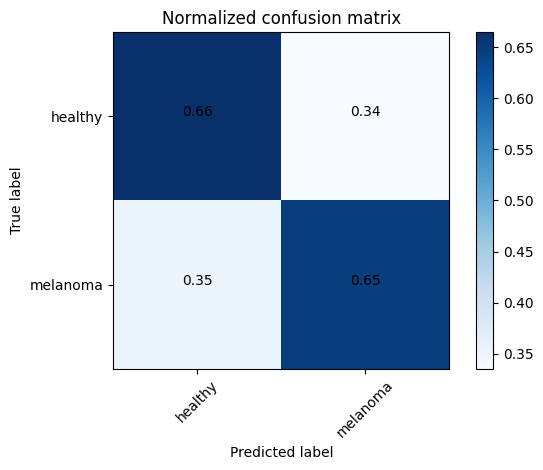

Fitting Linear SVM
 Average and std TRAIN CV f1 : 0.7301363493866131 +- 0.011800617591667126
 Average and std TEST CV f1 : 0.6884676551479666 +- 0.08094355679427633
 Average and std TRAIN CV recall : 0.7245550420665956 +- 0.023304726654722142
 Average and std TEST CV recall : 0.6882039573820397 +- 0.11708922405231273
 Average and std TRAIN CV roc_auc : 0.8005900980858996 +- 0.0074684060759701975
 Average and std TEST CV roc_auc : 0.7516850594596184 +- 0.04534817723466769
Best score: 0.745
              precision    recall  f1-score   support

           0       0.89      0.69      0.78       146
           1       0.33      0.65      0.44        34

    accuracy                           0.68       180
   macro avg       0.61      0.67      0.61       180
weighted avg       0.79      0.68      0.71       180

Normalized confusion matrix
[[0.69178082 0.30821918]
 [0.35294118 0.64705882]]


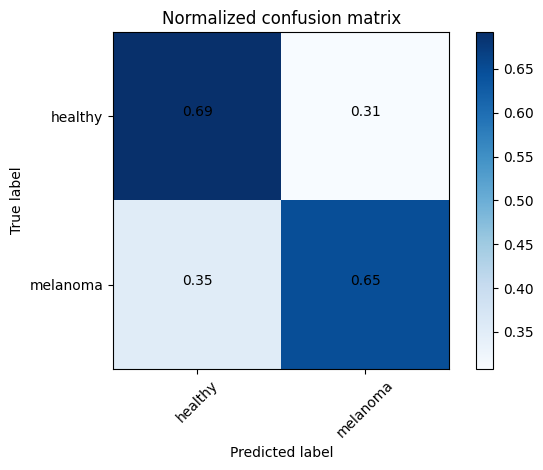

In [19]:
# Fitting Perceptron
print("Fitting Perceptron")
Perc = Perceptron()
Perc_cv = cross_validate(Perc,X_resampled, y_resampled,cv=5,scoring=('accuracy', 'f1','recall', 'roc_auc'),return_train_score=True,return_estimator=True)
print(Perc_cv.keys())
# print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Perc_cv['train_accuracy'].mean(), Perc_cv['train_accuracy'].std() ))
# print(" Average and std TEST CV accuracy : {0} +- {1}".format(Perc_cv['test_accuracy'].mean(), Perc_cv['test_accuracy'].std() ))
print(" Average and std TRAIN CV f1 : {0} +- {1}".format(Perc_cv['train_f1'].mean(), Perc_cv['train_f1'].std() ))
print(" Average and std TEST CV f1 : {0} +- {1}".format(Perc_cv['test_f1'].mean(), Perc_cv['test_f1'].std() ))
print(" Average and std TRAIN CV recall : {0} +- {1}".format(Perc_cv['train_recall'].mean(), Perc_cv['train_recall'].std() ))
print(" Average and std TEST CV recall : {0} +- {1}".format(Perc_cv['test_recall'].mean(), Perc_cv['test_recall'].std() ))
print(" Average and std TRAIN CV roc_auc : {0} +- {1}".format(Perc_cv['train_roc_auc'].mean(), Perc_cv['train_roc_auc'].std() ))
print(" Average and std TEST CV roc_auc : {0} +- {1}".format(Perc_cv['test_roc_auc'].mean(), Perc_cv['test_roc_auc'].std() ))

# Look for the best estimator (the one with the greatest test accuracy)
index_best = np.argmax(Perc_cv['test_accuracy'])
estimator_best=Perc_cv['estimator'][index_best]
y_pred = estimator_best.predict(X_test)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# print the best score
print("Best score: %0.3f" % Lsvm_cv['test_accuracy'][index_best])

# print the report of the best estimator
print(classification_report(y_test, y_pred))

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()


# Fitting linear SVM 
print("Fitting Linear SVM")
Lsvm = LinearSVC()
Lsvm_cv = cross_validate(Lsvm,X_resampled, y_resampled,cv=5,scoring=('accuracy', 'f1','recall', 'roc_auc'),return_train_score=True,return_estimator=True)
# print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Lsvm_cv['train_accuracy'].mean(), Lsvm_cv['train_accuracy'].std() ))
# print(" Average and std TEST CV accuracy : {0} +- {1}".format(Lsvm_cv['test_accuracy'].mean(), Lsvm_cv['test_accuracy'].std() ))
print(" Average and std TRAIN CV f1 : {0} +- {1}".format(Lsvm_cv['train_f1'].mean(), Lsvm_cv['train_f1'].std() ))
print(" Average and std TEST CV f1 : {0} +- {1}".format(Lsvm_cv['test_f1'].mean(), Lsvm_cv['test_f1'].std() ))
print(" Average and std TRAIN CV recall : {0} +- {1}".format(Lsvm_cv['train_recall'].mean(), Lsvm_cv['train_recall'].std() ))
print(" Average and std TEST CV recall : {0} +- {1}".format(Lsvm_cv['test_recall'].mean(), Lsvm_cv['test_recall'].std() ))
print(" Average and std TRAIN CV roc_auc : {0} +- {1}".format(Lsvm_cv['train_roc_auc'].mean(), Lsvm_cv['train_roc_auc'].std() ))
print(" Average and std TEST CV roc_auc : {0} +- {1}".format(Lsvm_cv['test_roc_auc'].mean(), Lsvm_cv['test_roc_auc'].std() ))

# Look for the best estimator (the one with the greatest test accuracy)
index_best = np.argmax(Lsvm_cv['test_accuracy'])
estimator_best=Lsvm_cv['estimator'][index_best]
y_pred = estimator_best.predict(X_test)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# print the best score
print("Best score: %0.3f" % Lsvm_cv['test_accuracy'][index_best])

# print the report of the best estimator
print(classification_report(y_test, y_pred))

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                        title='Normalized confusion matrix')
plt.show()

Suppose that there are overlapping classes, we need to set the hyper-parameter C for the SVM model. 

**Question** Use Cross-Validation on the oversampled data to find the best C value. Plot the confusion matrix using the best estimator (as before).

Best parameters set found on development set:
{'C': 3}
              precision    recall  f1-score   support

           0       0.89      0.70      0.78       146
           1       0.33      0.65      0.44        34

    accuracy                           0.69       180
   macro avg       0.61      0.67      0.61       180
weighted avg       0.79      0.69      0.72       180

Normalized confusion matrix
[[0.69863014 0.30136986]
 [0.35294118 0.64705882]]


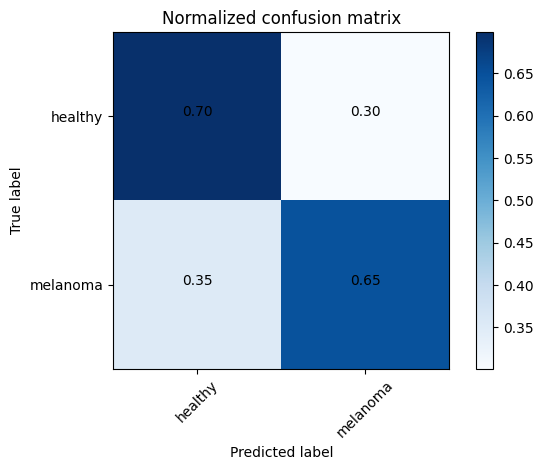

In [20]:
# Looking for the best hyperparameter C 
p_grid_lsvm = {'C': [1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,1e1]}
Lsvm = LinearSVC()
grid_lsvm = GridSearchCV(Lsvm, p_grid_lsvm, cv=5, scoring='accuracy',return_train_score=True)
grid_lsvm.fit(X_resampled, y_resampled)
print("Best parameters set found on development set:")  
print(grid_lsvm.best_params_)

y_true, y_pred = y_test, grid_lsvm.predict(X_test)

# print the report of the best estimator
print(classification_report(y_true, y_pred))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_true, y_pred)   
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                        title='Normalized confusion matrix')
plt.show()


Here it is the code for non-linear SVM using radial basis function. We need to tune another hyper-parameter $gamma$. We look for the best $C$ and $gamma$ at the same time.

**Question** Use Cross-Validation on the oversampled data to find the best C and $gamma$ value. Plot the confusion matrix using the best estimator (as before).

Fitting Non-linear SVM to the training set
Best parameters set found on development set using the kernel linear:
{'C': 4, 'gamma': 0.0001}
              precision    recall  f1-score   support

     healthy       0.88      0.66      0.75       146
    melanoma       0.30      0.62      0.40        34

    accuracy                           0.65       180
   macro avg       0.59      0.64      0.58       180
weighted avg       0.77      0.65      0.69       180

Normalized confusion matrix
[[0.65753425 0.34246575]
 [0.38235294 0.61764706]]


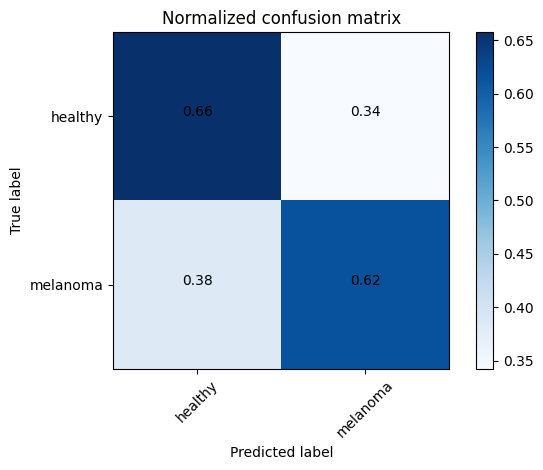

Best parameters set found on development set using the kernel rbf:
{'C': 3, 'gamma': 0.1}
              precision    recall  f1-score   support

     healthy       0.84      0.90      0.87       146
    melanoma       0.38      0.26      0.31        34

    accuracy                           0.78       180
   macro avg       0.61      0.58      0.59       180
weighted avg       0.75      0.78      0.76       180

Normalized confusion matrix
[[0.89726027 0.10273973]
 [0.73529412 0.26470588]]


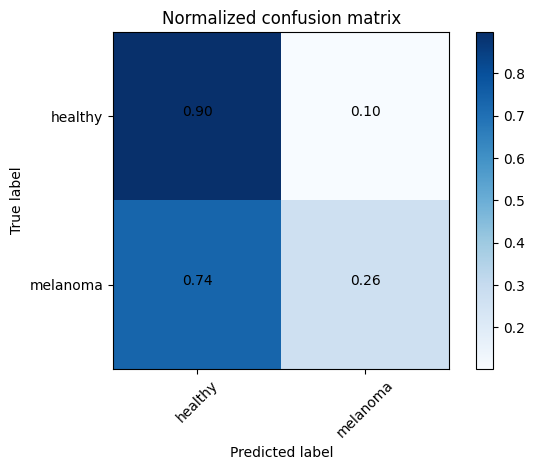

Best parameters set found on development set using the kernel poly:
{'C': 1, 'gamma': 0.1}
              precision    recall  f1-score   support

     healthy       0.86      0.70      0.77       146
    melanoma       0.29      0.53      0.38        34

    accuracy                           0.67       180
   macro avg       0.58      0.61      0.57       180
weighted avg       0.76      0.67      0.70       180

Normalized confusion matrix
[[0.69863014 0.30136986]
 [0.47058824 0.52941176]]


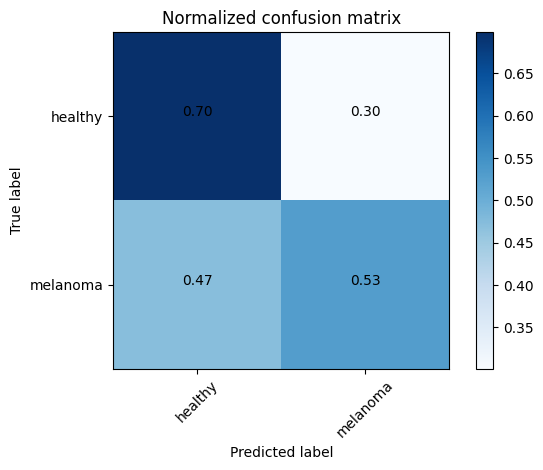

In [21]:
# Fitting Non-linear SVM

kernels = ['linear', 'rbf', 'poly', 'sigmoid']
print("Fitting Non-linear SVM to the training set")
t0 = time()
p_grid_nlsvm = {'C': [1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,1e1],
                'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }

for kernel in kernels:
    
    NLsvm = SVC(kernel=kernel)
    grid_nlsvm = GridSearchCV(NLsvm, p_grid_nlsvm, cv=5, scoring='accuracy',return_train_score=True)
    grid_nlsvm.fit(X_resampled, y_resampled)

    print("Best parameters set found on development set using the kernel %s:" % kernel)
    print(grid_nlsvm.best_params_)

    y_true, y_pred = y_test, grid_nlsvm.predict(X_test)
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_true, y_pred)
    # print the report of the classification
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                            title='Normalized confusion matrix')
    plt.show()

**Question** Use the non-linear SVM with the two strategies seen before (different scoring function and/or oversampled data). Do the results change ? Why in your opinion ?

**Answer:**

It is possible to observe below that the result changes for different scoring functions. As explained above this is due to the fact that each scoring function has a different way of evaluating the performance of the model. The 'accuracy' score is not a good metric is this specific task. 

On the other hand, the other scoring functions (precision, recall, f1-score and AUC-ROC) are more appropriate for this task because they take into account the number of true positives, false positives, true negatives, and false negatives, and they can be adjusted to reflect the specific cost of misclassification for different classes.



Fitting Non-linear SVM to the training set
Best parameters set found on development set using the kernel sigmoid:
{'C': 6, 'gamma': 0.005}
              precision    recall  f1-score   support

     healthy       0.92      0.75      0.83       146
    melanoma       0.41      0.74      0.53        34

    accuracy                           0.75       180
   macro avg       0.67      0.74      0.68       180
weighted avg       0.83      0.75      0.77       180

Normalized confusion matrix
[[0.75342466 0.24657534]
 [0.26470588 0.73529412]]


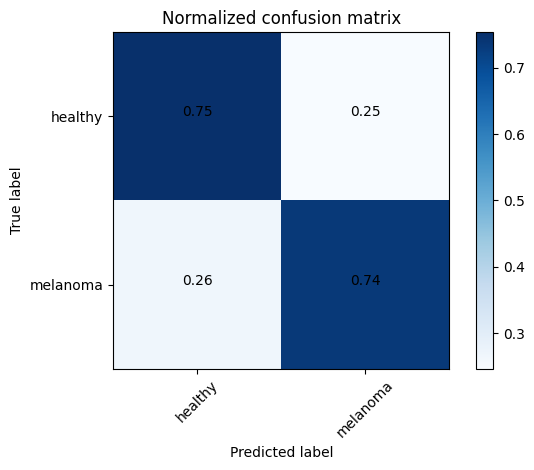

Best parameters set found on development set using the kernel sigmoid:
{'C': 3, 'gamma': 0.0005}
              precision    recall  f1-score   support

     healthy       0.90      0.81      0.85       146
    melanoma       0.43      0.62      0.51        34

    accuracy                           0.77       180
   macro avg       0.66      0.71      0.68       180
weighted avg       0.81      0.77      0.79       180

Normalized confusion matrix
[[0.80821918 0.19178082]
 [0.38235294 0.61764706]]


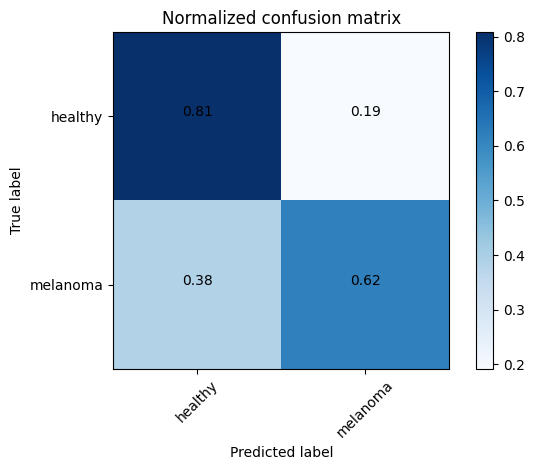

Best parameters set found on development set using the kernel sigmoid:
{'C': 0.001, 'gamma': 0.0001}
              precision    recall  f1-score   support

     healthy       0.00      0.00      0.00       146
    melanoma       0.19      1.00      0.32        34

    accuracy                           0.19       180
   macro avg       0.09      0.50      0.16       180
weighted avg       0.04      0.19      0.06       180

Normalized confusion matrix
[[0. 1.]
 [0. 1.]]


c:\Users\rocha\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\rocha\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\rocha\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


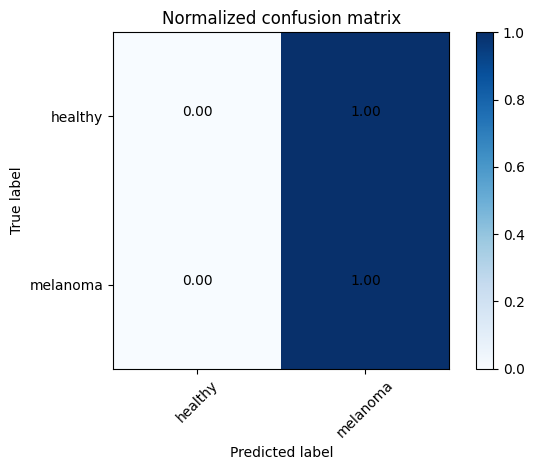

Best parameters set found on development set using the kernel sigmoid:
{'C': 4, 'gamma': 0.0001}
              precision    recall  f1-score   support

     healthy       0.90      0.37      0.52       146
    melanoma       0.23      0.82      0.36        34

    accuracy                           0.46       180
   macro avg       0.57      0.60      0.44       180
weighted avg       0.77      0.46      0.49       180

Normalized confusion matrix
[[0.36986301 0.63013699]
 [0.17647059 0.82352941]]


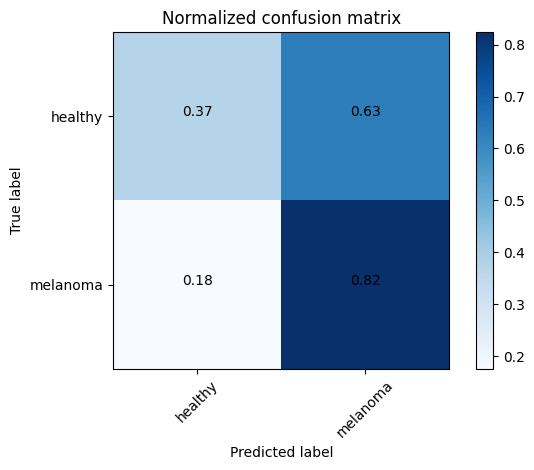

Best parameters set found on development set using the kernel sigmoid:
{'C': 5, 'gamma': 0.005}
              precision    recall  f1-score   support

     healthy       0.92      0.75      0.82       146
    melanoma       0.39      0.71      0.51        34

    accuracy                           0.74       180
   macro avg       0.65      0.73      0.66       180
weighted avg       0.82      0.74      0.76       180

Normalized confusion matrix
[[0.74657534 0.25342466]
 [0.29411765 0.70588235]]


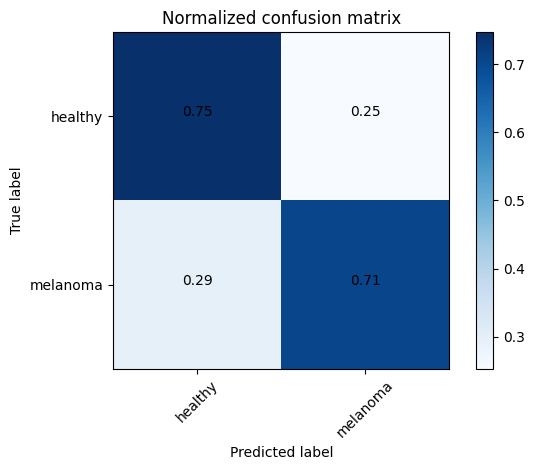

In [ ]:
# Fitting Non-linear SVM

kernels = ['linear', 'rbf', 'poly', 'sigmoid']
print("Fitting Non-linear SVM to the training set")
t0 = time()
p_grid_nlsvm = {'C': [1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,1e1],
                'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }

scoring_functions = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

for scoring in scoring_functions:
    NLsvm = SVC(kernel='sigmoid')
    grid_nlsvm = GridSearchCV(NLsvm, p_grid_nlsvm, cv=5, scoring=scoring,return_train_score=True)
    grid_nlsvm.fit(X_resampled, y_resampled)

    print("Best parameters set found on development set using the kernel %s:" % kernel)
    print(grid_nlsvm.best_params_)

    y_true, y_pred = y_test, grid_nlsvm.predict(X_test)
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_true, y_pred)
    # print the report of the classification
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                        title='Normalized confusion matrix')
    plt.show()

**Question** Try to draw a conclusion from the different experiments. Which is the best method ? Which scoring function should you use ? Is it worth it to oversample one of the two classes ?

**Answer:** 

The criterion for the choice of the best method depends on the problem at hand. In this case, the best method would be the one that presents the highest recall and f1-score for the minority class (melanoma). This is because the cost of misclassifying a melanoma lesion as benign is much higher than the cost of misclassifying a benign lesion as malignant. 

Consequently, the best method for this classification task is the non-linear SVM with the parameters C=6 and gamma=0.005 and with a sigmoid kernel. This method presents the highest recall and f1-score for the minority class (melanoma), which indicates a good balance between indentifying true positives and avoiding false negatives. 

The experiments suggest that oversampling the minority class can improve the performance of the models. Since this is a medical problem, the number of healthy patients is usually much higher than the number of patients with a disease. Therefore, the models are biased towards the majority class (benign lesions) and therefore it is more likely to predict a benign lesion than a malignant one. Oversampling the minority class, in this case, helped to balance the class distribution and reduce the bias.

The fact that the non-linear SVM provides better results indicates that the data is not linearly separable. 

**OPTIONAL** Another interesting question is: what about the number of features ? Can we reduce the dimensionality ? You could use one of the techniques seen during the previous lectures (i.e. PCA) ...

In [ ]:
# Test PCA with a linear SVM

# Another interesting question is: what about the number of features ? Can we
# reduce the dimensionality? You could use on of the techniques seen during the
# previous lectures (i.e. PCA)

# Fitting PCA
print("Fitting PCA to the training set")
t0 = time()
pca = PCA(n_components=2)
pca.fit(X_train)



Fitting PCA to the training set


PCA(n_components=2)

In [ ]:
# Fitting Linear SVM 
print("Fitting Linear SVM to the training set")
t0 = time()
p_grid_lsvm = {'C': [1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,1e1]}
Lsvm = LinearSVC()
grid_lsvm = GridSearchCV(Lsvm, p_grid_lsvm, cv=5, scoring='accuracy',return_train_score=True)
grid_lsvm.fit(X_resampled, y_resampled)
print("Best parameters set found on development set:")
print(grid_lsvm.best_params_)
print("Grid scores on development set:")
means = grid_lsvm.cv_results_['mean_test_score']
stds = grid_lsvm.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_lsvm.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
print("Detailed classification report:")
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
y_true, y_pred = y_test, grid_lsvm.predict(X_test)

Fitting Linear SVM to the training set
Best parameters set found on development set:
{'C': 5}
Grid scores on development set:
0.659 (+/-0.083) for {'C': 0.001}
0.669 (+/-0.035) for {'C': 0.01}
0.676 (+/-0.052) for {'C': 0.1}
0.679 (+/-0.062) for {'C': 1}
0.681 (+/-0.057) for {'C': 2}
0.679 (+/-0.069) for {'C': 3}
0.676 (+/-0.057) for {'C': 4}
0.684 (+/-0.067) for {'C': 5}
0.676 (+/-0.068) for {'C': 6}
0.678 (+/-0.036) for {'C': 7}
0.668 (+/-0.060) for {'C': 8}
0.668 (+/-0.072) for {'C': 9}
0.663 (+/-0.066) for {'C': 10.0}
Detailed classification report:
The model is trained on the full development set.
The scores are computed on the full evaluation set.


**OPTIONAL** ... or test the importance of the single features.
The more naive technique would be to test each feature independently in a greedy fashion called sequential forward feature selection. Starting from an empty set and a classification model, you will first add the feature that maximizes a certain criterion (i.e. f1 score). Then, you will iterate this process until a chosen stopping criterion by adding at each iteration only the best feature. Each feature can be added of course only once. You could also use the opposite process by removing at each iteraton the least important feature starting from the entire set of features (i.e. sequential backward feature selection). Implement at least one of these ideas. 

Number of features selected:  27
Number of features removed:  3
Number of features in the original dataset:  30
Fitting Linear SVM to the training set
Best parameters set found on development set:
{'C': 0.1}
Grid scores on development set:
0.819 (+/-0.032) for {'C': 0.001}
0.833 (+/-0.034) for {'C': 0.01}
0.845 (+/-0.054) for {'C': 0.1}
0.838 (+/-0.061) for {'C': 1}
0.840 (+/-0.058) for {'C': 2}
0.843 (+/-0.055) for {'C': 3}
0.843 (+/-0.057) for {'C': 4}
0.840 (+/-0.058) for {'C': 5}
0.838 (+/-0.067) for {'C': 6}
0.845 (+/-0.052) for {'C': 7}
0.831 (+/-0.055) for {'C': 8}
0.831 (+/-0.070) for {'C': 9}
0.826 (+/-0.076) for {'C': 10.0}
Detailed classification report:
The model is trained on the full development set.
The scores are computed on the full evaluation set.
Normalized confusion matrix
[[0.96575342 0.03424658]
 [0.76470588 0.23529412]]


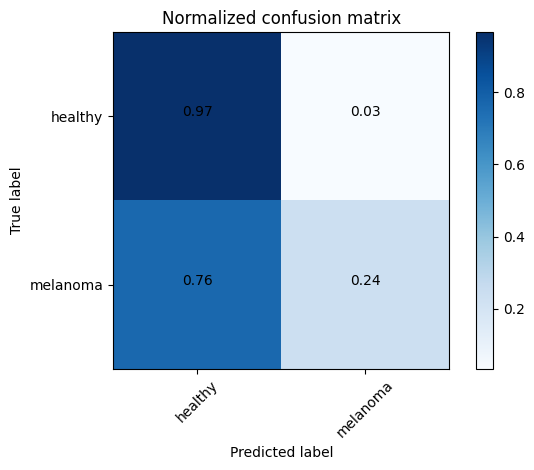

In [ ]:
# Implement sequential forward feature selection 
# import 
from sklearn.feature_selection import SequentialFeatureSelector as SFS
from sklearn.metrics import f1_score

X_train_sfs = X_train.copy()
X_test_sfs = X_test.copy()
X_train_selected = []
X_test_selected = []
n_features_selected = 0

while n_features_selected < X_train.shape[1]*0.9:
    # take the feature that gives the best f1 score
    best_feature = 0
    best_score = 0

    for i in range(X_train_sfs.shape[1]):
        lsvm = LinearSVC()
        lsvm.fit(X_train_sfs[:,i].reshape(-1,1), y_train)
        score = f1_score(y_test, lsvm.predict(X_test_sfs[:,i].reshape(-1,1)))
        if score > best_score:
            best_feature = i
            best_score = score
    # add the best feature to the selected features
    X_train_selected.append(X_train_sfs[:,best_feature])
    X_test_selected.append(X_test_sfs[:,best_feature])
    
    # remove the best feature from the features to select
    X_train_sfs = np.delete(X_train_sfs, best_feature, axis=1)
    X_test_sfs = np.delete(X_test_sfs, best_feature, axis=1)
    
    n_features_selected+=1
    
print("Number of features selected: ", n_features_selected)
print("Number of features removed: ", X_train_sfs.shape[1])
print("Number of features in the original dataset: ", X_train.shape[1])

X_train_selected = np.array(X_train_selected).T
X_test_selected = np.array(X_test_selected).T

# Fitting Linear SVM
print("Fitting Linear SVM to the training set")
t0 = time()
p_grid_lsvm = {'C': [1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,1e1]}
Lsvm = LinearSVC()
grid_lsvm = GridSearchCV(Lsvm, p_grid_lsvm, cv=5, scoring='accuracy',return_train_score=True)
grid_lsvm.fit(X_train_selected, y_train)
print("Best parameters set found on development set:")
print(grid_lsvm.best_params_)
print("Grid scores on development set:")
means = grid_lsvm.cv_results_['mean_test_score']
stds = grid_lsvm.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_lsvm.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
print("Detailed classification report:")
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
y_true, y_pred = y_test, grid_lsvm.predict(X_test_selected)


plot_confusion_matrix(confusion_matrix(y_true, y_pred), classes=class_names, normalize=True,
                        title='Normalized confusion matrix')
plt.show()

    


Number of features removed:  3
Number of features selected:  27
Number of features in the original dataset:  30
Fitting Linear SVM to the training set
Best parameters set found on development set:
{'C': 0.1}
Grid scores on development set:
0.659 (+/-0.063) for {'C': 0.001}
0.657 (+/-0.032) for {'C': 0.01}
0.660 (+/-0.033) for {'C': 0.1}
0.659 (+/-0.039) for {'C': 1}
0.659 (+/-0.034) for {'C': 2}
0.655 (+/-0.038) for {'C': 3}
0.660 (+/-0.039) for {'C': 4}
0.659 (+/-0.042) for {'C': 5}
0.650 (+/-0.037) for {'C': 6}
0.643 (+/-0.033) for {'C': 7}
0.649 (+/-0.040) for {'C': 8}
0.646 (+/-0.080) for {'C': 9}
0.636 (+/-0.050) for {'C': 10.0}
Detailed classification report:
The model is trained on the full development set.
The scores are computed on the full evaluation set.
Normalized confusion matrix
[[0.71917808 0.28082192]
 [0.35294118 0.64705882]]


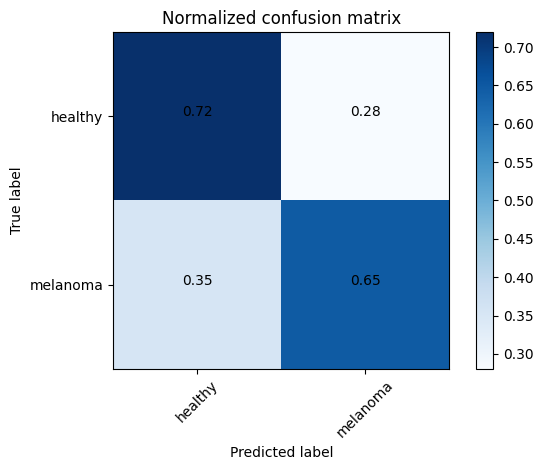

In [ ]:
# Implement forward feature selection and/or backward feature selection
# with a linear SVM

# Now implement backward feature selection

X_train_selected = X_resampled.copy()
X_test_selected = X_test.copy()
y_train_selected = y_resampled.copy()
y_test_selected = y_test.copy()

n_features_removed = 0
ai = 0
while n_features_removed < X_train.shape[1]*0.1:
    # take the feature that gives the best f1 score
    worst_feature = 0
    worst_score = 1
        
    for i in range(X_train_selected.shape[1]):
        lsvm = LinearSVC()
        lsvm.fit(X_train_selected[:,i].reshape(-1,1), y_train_selected)
        score = f1_score(y_test_selected, lsvm.predict(X_test_selected[:,i].reshape(-1,1)))
        if score < worst_score:
            worst_feature = i
            worst_score = score
    # remove the worst feature from the selected features
    X_train_selected = np.delete(X_train_selected, worst_feature, axis=1)
    X_test_selected = np.delete(X_test_selected, worst_feature, axis=1)
    
    
    n_features_removed +=1

print("Number of features removed: ", n_features_removed)
print("Number of features selected: ", X_train_selected.shape[1])
print("Number of features in the original dataset: ", X_train.shape[1])

# Fitting Linear SVM
print("Fitting Linear SVM to the training set")
t0 = time()
p_grid_lsvm = {'C': [1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,1e1]}
Lsvm = LinearSVC()
grid_lsvm = GridSearchCV(Lsvm, p_grid_lsvm, cv=5, scoring='accuracy',return_train_score=True)
grid_lsvm.fit(X_train_selected, y_train_selected)
print("Best parameters set found on development set:")
print(grid_lsvm.best_params_)
print("Grid scores on development set:")
means = grid_lsvm.cv_results_['mean_test_score']
stds = grid_lsvm.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_lsvm.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
print("Detailed classification report:")
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
y_true, y_pred = y_test_selected, grid_lsvm.predict(X_test_selected)

plot_confusion_matrix(confusion_matrix(y_true, y_pred), classes=class_names, normalize=True,
                        title='Normalized confusion matrix')
plt.show()

